RAW DATA:
     Store      Jan      Feb      Mar      Apr
0  Store_A  15000.0  18000.0      NaN  17000.0
1  Store_B  12000.0  12500.0  13000.0      NaN
2  Store_C  14000.0  13800.0  14200.0  14500.0
3  Store_D  13500.0      NaN  13700.0  13900.0
4  Store_E      NaN  11000.0  12000.0  11800.0
5  Store_B  12000.0  12500.0  13000.0      NaN
6  Store_A  15000.0  18000.0      NaN  17000.0
7  Store_C      NaN  13800.0  14200.0  14500.0
8  Store_D  13500.0  13400.0  13700.0      NaN
9  Store_E  11500.0      NaN  12000.0  11800.0

After dropping exact duplicates and aggregating repeated Store rows (means):
     Store      Jan      Feb      Mar      Apr
0  Store_A  15000.0  18000.0      NaN  17000.0
1  Store_B  12000.0  12500.0  13000.0      NaN
2  Store_C  14000.0  13800.0  14200.0  14500.0
3  Store_D  13500.0  13400.0  13700.0  13900.0
4  Store_E  11500.0  11000.0  12000.0  11800.0

After imputation (cleaned dataset):
     Store      Jan      Feb           Mar      Apr
0  Store_A  15000.0  180

<Figure size 1080x600 with 0 Axes>

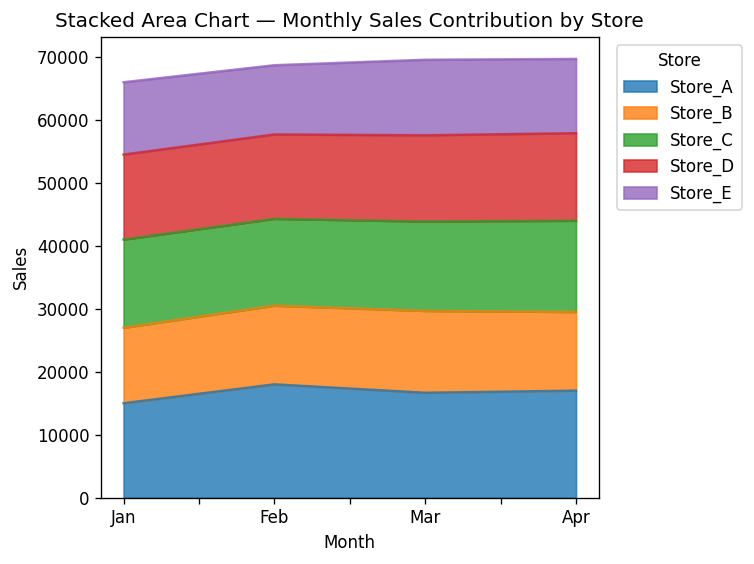

Saved area chart: output/area_chart_stacked.png


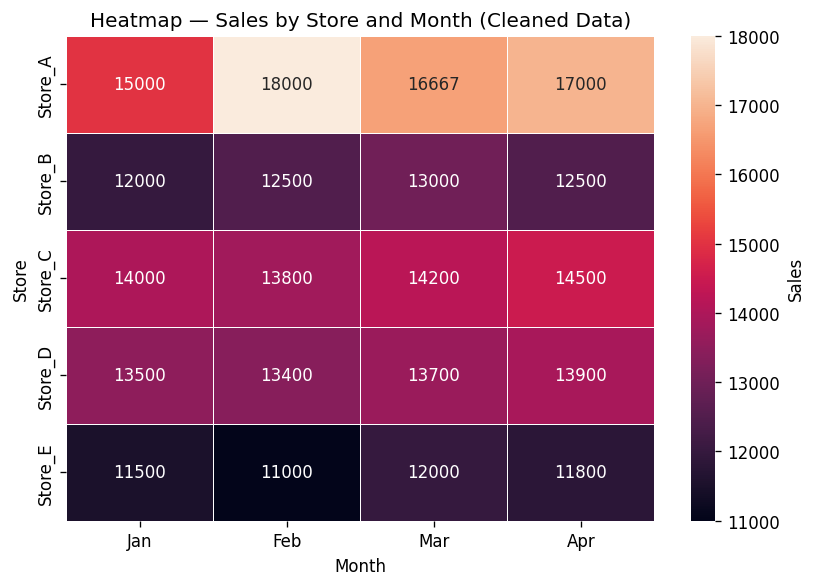

Saved heatmap: output/heatmap_sales_table.png


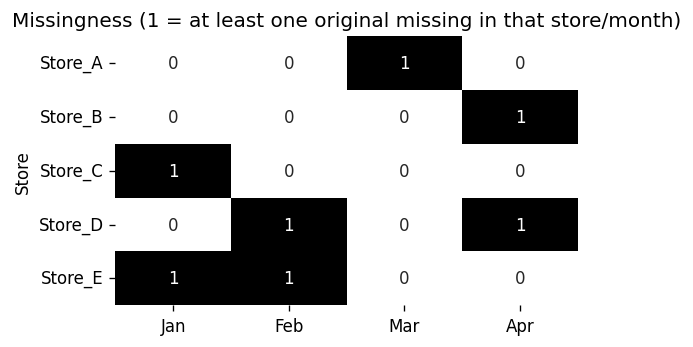

Saved missingness mask: output/missingness_mask.png


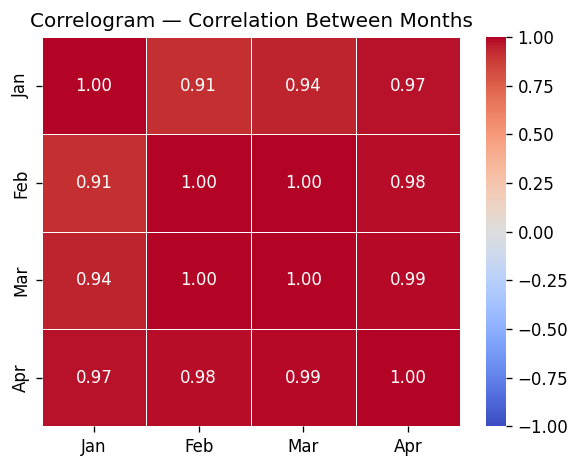

Saved correlogram: output/correlogram_months.png


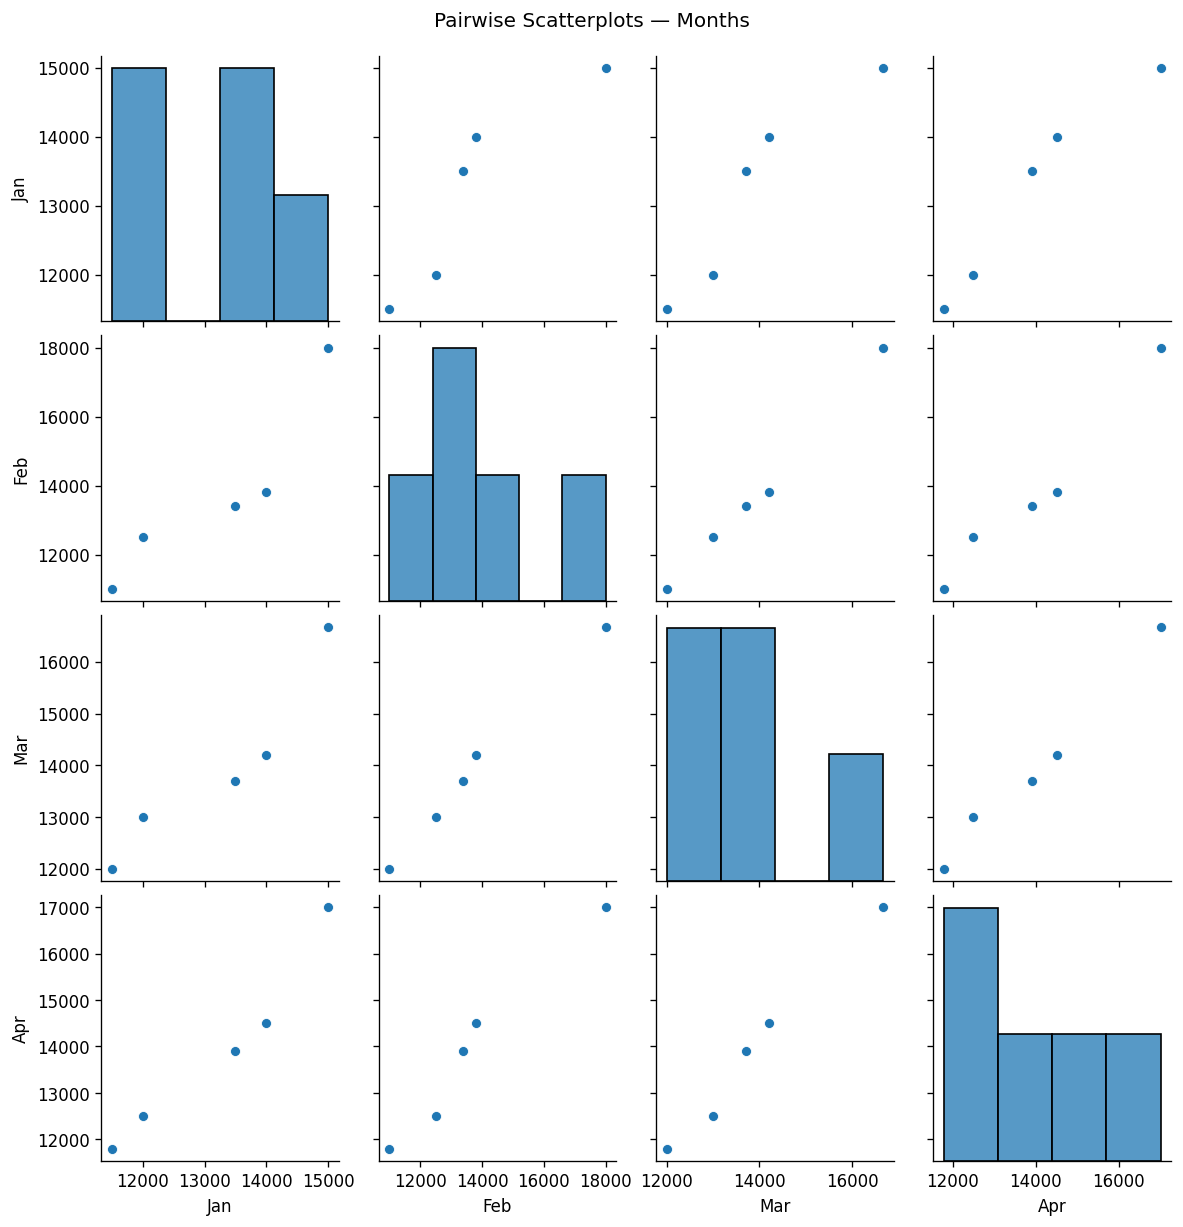

Saved pairplot (pairwise scatter): output/pairplot_months.png

Numeric summaries (cleaned):
----------------------------------------
Monthly totals (across stores):
Jan    66000.000000
Feb    68700.000000
Mar    69566.666667
Apr    69700.000000
dtype: float64

Monthly means (across stores):
Jan    13200.000000
Feb    13740.000000
Mar    13913.333333
Apr    13940.000000
dtype: float64

Correlation matrix (months):
          Jan       Feb       Mar       Apr
Jan  1.000000  0.913908  0.940953  0.971413
Feb  0.913908  1.000000  0.996571  0.981623
Mar  0.940953  0.996571  1.000000  0.991949
Apr  0.971413  0.981623  0.991949  1.000000


In [1]:
# sales_store_visuals.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ----------------------------
# 1) Raw dataset (as provided)
# ----------------------------
data = {
    "Store": [
        "Store_A","Store_B","Store_C","Store_D","Store_E",
        "Store_B","Store_A","Store_C","Store_D","Store_E"
    ],
    "Jan": [
        15000,12000,14000,13500,np.nan,
        12000,15000,np.nan,13500,11500
    ],
    "Feb": [
        18000,12500,13800,np.nan,11000,
        12500,18000,13800,13400,np.nan
    ],
    "Mar": [
        np.nan,13000,14200,13700,12000,
        13000,np.nan,14200,13700,12000
    ],
    "Apr": [
        17000,np.nan,14500,13900,11800,
        np.nan,17000,14500,np.nan,11800
    ]
}

df_raw = pd.DataFrame(data)
print("RAW DATA:")
print(df_raw)

# --------------------------------
# 2) Clean duplicates & aggregate
# --------------------------------
# Step A: drop exact duplicate rows (identical rows)
df = df_raw.drop_duplicates().reset_index(drop=True)

# Step B: If the same Store appears in multiple rows (not exactly identical),
# aggregate by Store taking the mean across rows (so multiple entries per store are merged).
# This deals with repeated Store_A and Store_B rows in your raw data.
months = ["Jan","Feb","Mar","Apr"]
df = df.groupby("Store", as_index=False)[months].mean()

print("\nAfter dropping exact duplicates and aggregating repeated Store rows (means):")
print(df)

# --------------------------------
# 3) Impute missing values
# --------------------------------
# Strategy:
#  - For each missing month value for a store: fill with that store's mean across available months
#  - If store's mean is NaN (unlikely after aggregation but safe), fall back to overall month mean

# compute store-level (row) means (across months) and month-level means (across stores)
df["Store_Mean"] = df[months].mean(axis=1)
month_means = df[months].mean(axis=0)

# Impute
for m in months:
    # If a store's month is missing, try store mean then month mean
    df[m] = df.apply(
        lambda row: row[m]
        if not pd.isna(row[m])
        else (row["Store_Mean"] if not pd.isna(row["Store_Mean"]) else month_means[m]),
        axis=1
    )

# Drop temporary Store_Mean column
df = df.drop(columns=["Store_Mean"])

# Ensure numeric type
df[months] = df[months].astype(float)

print("\nAfter imputation (cleaned dataset):")
print(df)

# Save cleaned dataset
os.makedirs("output", exist_ok=True)
cleaned_csv_path = os.path.join("output", "cleaned_store_sales.csv")
df.to_csv(cleaned_csv_path, index=False)
print(f"\nCleaned dataset saved to: {cleaned_csv_path}")

# --------------------------------
# 4) Visualizations
# --------------------------------
plt.rcParams.update({"figure.dpi": 120})

# A) Area Chart — Stacked area showing monthly totals per store across months
# For an area chart we want months on x-axis and sales per store as series.
# Create a DataFrame with months as index and stores as columns (transpose).
area_df = df.set_index("Store").T  # index = months, columns = stores

# Reorder index to ensure months order
area_df = area_df.reindex(months)

plt.figure(figsize=(9,5))
area_df.plot(kind="area", stacked=True, alpha=0.8)
plt.title("Stacked Area Chart — Monthly Sales Contribution by Store")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(rotation=0)
plt.legend(title="Store", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
area_path = os.path.join("output", "area_chart_stacked.png")
plt.savefig(area_path)
plt.show()
print(f"Saved area chart: {area_path}")

# B) Heatmap — visual of the cleaned sales table (stores as rows, months as columns)
plt.figure(figsize=(7,5))
sns.heatmap(df.set_index("Store")[months], annot=True, fmt=".0f", linewidths=0.5, cbar_kws={"label":"Sales"})
plt.title("Heatmap — Sales by Store and Month (Cleaned Data)")
plt.xlabel("Month")
plt.ylabel("Store")
plt.tight_layout()
heatmap_path = os.path.join("output", "heatmap_sales_table.png")
plt.savefig(heatmap_path)
plt.show()
print(f"Saved heatmap: {heatmap_path}")

# (Optional useful diagnostic) Heatmap of missingness BEFORE imputation — showing where data was missing originally.
# This is informative to show how much you imputed.
orig_missing = df_raw.copy()
# create boolean missing mask per original rows aggregated to store-level (if any original row for store had NaN in that month, show True)
missing_mask = orig_missing.groupby("Store")[months].apply(lambda group: group.isna().any()).astype(int)
plt.figure(figsize=(5,3))
sns.heatmap(missing_mask, annot=True, fmt="d", cmap="Greys", cbar=False)
plt.title("Missingness (1 = at least one original missing in that store/month)")
plt.tight_layout()
missing_mask_path = os.path.join("output", "missingness_mask.png")
plt.savefig(missing_mask_path)
plt.show()
print(f"Saved missingness mask: {missing_mask_path}")

# C) Correlogram — correlation matrix heatmap (months correlation)
# Compute correlation between months (are Jan sales correlated with Feb etc.)
corr = df[months].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="coolwarm", linewidths=0.5)
plt.title("Correlogram — Correlation Between Months")
plt.tight_layout()
corr_path = os.path.join("output", "correlogram_months.png")
plt.savefig(corr_path)
plt.show()
print(f"Saved correlogram: {corr_path}")

# Also optionally show pairwise scatterplot with regression lines to get a visual sense (pairplot)
pairplot_path = os.path.join("output", "pairplot_months.png")
sns.pairplot(df[months])
plt.suptitle("Pairwise Scatterplots — Months", y=1.02)
plt.savefig(pairplot_path, bbox_inches="tight")
plt.show()
print(f"Saved pairplot (pairwise scatter): {pairplot_path}")

# --------------------------------
# 5) Quick numeric outputs (direct, clear)
# --------------------------------
print("\nNumeric summaries (cleaned):")
print("-" * 40)
print("Monthly totals (across stores):")
print(df[months].sum())
print("\nMonthly means (across stores):")
print(df[months].mean())
print("\nCorrelation matrix (months):")
print(corr)
